# Feature Based Traffic Classification 


Network Measurement and Data Analysis Lab Homework 2 - Fatih Temiz 10901682

Feature Based Traffic Classification handled, packets are captured for each given url 10 times and stored in separate files. Then all csv files aggregated in one dataframe, features extracted for both uplink and downlink flows. TCP connections including TLS and TCP are used with both downlink and uplink features. Final dataframes includes 10 rows per URL in first task and 3 rows per URL in second test task. Several scaling and encoding scheme used in first task and label encoding & MinMax scaler gave the best result; k varied from 1 to 11 and confusion matrices for each scenario obtained. Accuracy dropped with unseen test dataset(3 visit) like %10 in selected scenario.




-dataset_creator.py: this file used for both sending requests and capturing with pyshark. I used WSL(Windows Subsystem for Linux to be able to capture via eth0(I encountered problem with windows version). With Threading; I am able to send requests and sniff them concurrently. Captured and filtered packets stored in .csv files for each url.

-dataset_aggregator.py: this code utilized for aggregating multiple csv's into one 

 Importing Libraries

In [1]:
import pandas as pd 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np



In [2]:
aggregated_df=pd.read_csv("C:/Users/fatih.temiz/TrafficClassification/aggregated_data_with_udp_corrected.csv")
alternated_df=pd.read_csv("C:/Users/fatih.temiz/TrafficClassification/aggregated_data_with_udp_corrected_with_3_requests.csv")

## I uploaded aggregated_df for 10 visit and 3 visit(alternated_df)

In [3]:
aggregated_df

,Unnamed: 0,source_ip,destination_ip,protocol,top_layer,packet_length,packet_number,capture_time,timestamp,source_port,...,dns_query,dns_response,dns_type,dns_class,query_count,answer_count,authority_count,udp_source_port,udp_destination_port,label
0,0,23.79.95.79,192.168.159.238,6,TLS,1394,1,2024-03-27 02:35:42.036794,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
1,1,192.168.159.238,23.79.95.79,6,TCP,54,2,2024-03-27 02:35:42.036820,1.711503e+09,48616.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
2,2,23.79.95.79,192.168.159.238,6,TCP,1394,3,2024-03-27 02:35:42.046378,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
3,3,23.79.95.79,192.168.159.238,6,TCP,2734,4,2024-03-27 02:35:42.046379,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
4,4,23.79.95.79,192.168.159.238,6,TCP,2734,5,2024-03-27 02:35:42.046379,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33647,2485,76.223.84.192,192.168.159.238,6,TCP,54,2488,2024-03-27 02:51:10.144854,1.711504e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
33648,2486,192.168.159.238,76.223.84.192,6,TCP,54,2489,2024-03-27 02:51:10.144863,1.711504e+09,35694.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
33649,2487,192.168.144.1,224.0.0.251,17,MDNS,87,2490,2024-03-27 02:51:10.448906,1.711504e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5353.0,5353.0,news_yahoo
33650,2488,192.168.144.1,239.255.255.250,17,SSDP,167,2492,2024-03-27 02:51:14.692922,1.711504e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58076.0,1900.0,news_yahoo


In [4]:
alternated_df

,Unnamed: 0,source_ip,destination_ip,protocol,top_layer,packet_length,packet_number,capture_time,timestamp,source_port,...,dns_query,dns_response,dns_type,dns_class,query_count,answer_count,authority_count,udp_source_port,udp_destination_port,label
0,0,23.51.246.151,172.20.146.77,6,TCP,66,1,2024-03-28 01:34:33.985252,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
1,1,172.20.146.77,23.51.246.151,6,TCP,54,2,2024-03-28 01:34:33.985401,1.711586e+09,38640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
2,2,172.20.146.77,23.51.246.151,6,TLS,571,3,2024-03-28 01:34:34.061599,1.711586e+09,38640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
3,3,23.51.246.151,172.20.146.77,6,TCP,54,4,2024-03-28 01:34:34.122415,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
4,4,23.51.246.151,172.20.146.77,6,TLS,1394,5,2024-03-28 01:34:34.145926,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10899,701,172.20.146.77,76.223.84.192,6,TCP,54,702,2024-03-28 01:46:24.489844,1.711587e+09,49534.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10900,702,87.248.107.206,172.20.146.77,6,TCP,54,703,2024-03-28 01:46:24.496116,1.711587e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10901,703,87.248.107.206,172.20.146.77,6,TCP,54,704,2024-03-28 01:46:24.496132,1.711587e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10902,704,172.20.146.77,87.248.107.206,6,TCP,54,705,2024-03-28 01:46:24.496140,1.711587e+09,48898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo


## BiFlow Features Extracted Here 

In [5]:

def extract_features(flow, df_flow):
    flow_features = {}
    # According to my IP address
    if flow[0].split('.')[0] == '192' and flow[0].split('.')[1] == '168' and flow[0].split('.')[2]=='159' :
        flow_features['direction'] = 'uplink'
    else:
        flow_features['direction'] = 'downlink'

    
    flow_features['num_packets'] = len(df_flow)
    pkt_sizes = df_flow['packet_length'].astype(float)
    flow_features['total_bytes'] = pkt_sizes.sum()
    flow_features['min_pkt_size'] = pkt_sizes.min()
    flow_features['max_pkt_size'] = pkt_sizes.max()
    flow_features['mean_pkt_size'] = pkt_sizes.mean()
    flow_features['std_pkt_size'] = pkt_sizes.std()
    
    
   
    iat = pd.to_datetime(df_flow['capture_time']).diff().dt.total_seconds().iloc[1:]
    flow_features['min_iat'] = iat.min()
    flow_features['max_iat'] = iat.max()
    flow_features['mean_iat'] = iat.mean()
    flow_features['std_iat'] = iat.std()
    flow_features['dur'] = iat.sum()
    flow_features['label']=df_flow['label']
    
    
    flow_features['destinationport'] = flow[3]
    flow_features['sourceport'] = flow[2]
    
    return flow_features




In [6]:
aggregated_df

,Unnamed: 0,source_ip,destination_ip,protocol,top_layer,packet_length,packet_number,capture_time,timestamp,source_port,...,dns_query,dns_response,dns_type,dns_class,query_count,answer_count,authority_count,udp_source_port,udp_destination_port,label
0,0,23.79.95.79,192.168.159.238,6,TLS,1394,1,2024-03-27 02:35:42.036794,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
1,1,192.168.159.238,23.79.95.79,6,TCP,54,2,2024-03-27 02:35:42.036820,1.711503e+09,48616.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
2,2,23.79.95.79,192.168.159.238,6,TCP,1394,3,2024-03-27 02:35:42.046378,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
3,3,23.79.95.79,192.168.159.238,6,TCP,2734,4,2024-03-27 02:35:42.046379,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
4,4,23.79.95.79,192.168.159.238,6,TCP,2734,5,2024-03-27 02:35:42.046379,1.711503e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33647,2485,76.223.84.192,192.168.159.238,6,TCP,54,2488,2024-03-27 02:51:10.144854,1.711504e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
33648,2486,192.168.159.238,76.223.84.192,6,TCP,54,2489,2024-03-27 02:51:10.144863,1.711504e+09,35694.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
33649,2487,192.168.144.1,224.0.0.251,17,MDNS,87,2490,2024-03-27 02:51:10.448906,1.711504e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5353.0,5353.0,news_yahoo
33650,2488,192.168.144.1,239.255.255.250,17,SSDP,167,2492,2024-03-27 02:51:14.692922,1.711504e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58076.0,1900.0,news_yahoo


In [7]:
aggregated_df['protocol'] = aggregated_df['protocol'].astype(int)

# Filter for TCP/TLS and UDP/DNS traffic,  protocol 6 is TCP and 17 is UDP
df_tcp_tls = aggregated_df[aggregated_df["protocol"] == 6]
df_udp_dns = aggregated_df[aggregated_df["protocol"] == 17]


df_flows_tcp = df_tcp_tls.groupby(["source_ip", "destination_ip", "source_port", "destination_port"])
df_flows_udp=df_udp_dns.groupby(["source_ip", "destination_ip", "udp_source_port", "udp_destination_port"])


In [8]:
df_flows_udp

In [9]:
flow_features_df_tcp=pd.DataFrame()
flow_features_df_udp=pd.DataFrame()


flow_features_list = []
for flow, df_flow in df_flows_tcp:
    # Extract features for the flow
    features = extract_features(flow, df_flow)
    # Extract label from the first row in the group
    features['label'] = df_flow.iloc[0]["label"]
    # Append the combined dictionary to the list
    flow_features_list.append(features)
    
flow_features_list_udp = []
for flow, df_flow in df_flows_udp:
    # Extract features for the flow
    features = extract_features(flow, df_flow)
    # Extract label from the first row in the group
    features['label'] = df_flow.iloc[0]["label"]
    # Append the combined dictionary to the list
    flow_features_list_udp.append(features)

# Create DataFrames from the lists of dictionaries
flow_features_df_tcp = pd.DataFrame(flow_features_list)
flow_features_df_udp = pd.DataFrame(flow_features_list_udp)


## Here there are two different dataframe one for tcp and one for udp. It contains 10 downlink 10 uplink per each CURL.

In [12]:
flow_features_df_tcp[flow_features_df_tcp["label"]=='ndtv']

,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,label,destinationport,sourceport
0,downlink,46,82361.0,54.0,5414.0,1790.456522,1101.195486,0.000000,0.293340,0.014429,0.047595,0.649292,ndtv,56442.0,443.0
1,downlink,42,82115.0,54.0,4074.0,1955.119048,1047.058766,0.000000,0.275683,0.012483,0.045657,0.511799,ndtv,56444.0,443.0
2,downlink,40,82007.0,54.0,6754.0,2050.175000,1370.679055,0.000000,0.285734,0.013230,0.048237,0.515952,ndtv,56446.0,443.0
3,downlink,47,82376.0,54.0,4074.0,1752.680851,1010.820827,0.000000,0.298303,0.011806,0.046164,0.543098,ndtv,56448.0,443.0
4,downlink,40,82005.0,54.0,4074.0,2050.125000,1110.985730,0.000000,0.287035,0.016934,0.054082,0.660408,ndtv,56450.0,443.0
5,downlink,38,81889.0,54.0,4074.0,2154.973684,1168.559277,0.000000,0.488926,0.019491,0.081308,0.721162,ndtv,56452.0,443.0
6,downlink,50,82546.0,54.0,2734.0,1650.920000,868.020616,0.000000,0.303417,0.011595,0.045916,0.568171,ndtv,56454.0,443.0
7,downlink,48,82439.0,54.0,4074.0,1717.479167,965.084650,0.000000,0.289817,0.011413,0.044570,0.536396,ndtv,56456.0,443.0
8,downlink,45,82265.0,54.0,4074.0,1828.111111,1067.207725,0.000000,0.304883,0.012396,0.048029,0.545441,ndtv,56458.0,443.0
9,downlink,49,82488.0,54.0,4074.0,1683.428571,954.206629,0.000000,0.107175,0.006728,0.019138,0.322931,ndtv,56460.0,443.0


## Here I modified dataframes to be able to obtain a dataframe that contains 10 rows per label 

In [15]:

df=flow_features_df_tcp
# Splitting the DataFrame based on direction
df_uplink = df[df['direction'] == 'uplink'].copy()
df_downlink = df[df['direction'] == 'downlink'].copy()


uplink_rename_cols = {col: f"{col}_up" for col in df_uplink.columns if col not in ['direction', 'label', 'sourceport', 'destinationport']}
downlink_rename_cols = {col: f"{col}_down" for col in df_downlink.columns if col not in ['direction', 'label', 'sourceport', 'destinationport']}

df_uplink.rename(columns=uplink_rename_cols, inplace=True)
df_downlink.rename(columns=downlink_rename_cols, inplace=True)

df_uplink.rename(columns={'sourceport': 'sourceport_up', 'destinationport': 'destinationport_up'}, inplace=True)
df_downlink.rename(columns={'sourceport': 'sourceport_down', 'destinationport': 'destinationport_down'}, inplace=True)

#Merging splitted dataframes to be able to obtain row per each label
df_combined = pd.merge(df_downlink, df_uplink, 
                       left_on=['label', 'destinationport_down', 'sourceport_down'], 
                       right_on=['label', 'sourceport_up', 'destinationport_up'], 
                       how='inner')

df_combined.drop(columns=['sourceport_up', 'destinationport_up', 'sourceport_down', 'destinationport_down'], inplace=True)




if 'direction_x' and 'direction_y' in df_combined.columns:
    df_combined.drop(columns=['direction_x','direction_y'], inplace=True)

cols = [col for col in df_combined.columns if col != 'label']

cols = ['label'] + cols

df_combined = df_combined[cols]

df_cleaned = df_combined.dropna()


In [16]:
df_cleaned

,label,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,mean_iat_down,...,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,dur_up
0,ndtv,46,82361.0,54.0,5414.0,1790.456522,1101.195486,0.0,0.293340,0.014429,...,2834.0,54.0,571.0,74.578947,87.799105,0.000002,0.251043,0.018742,0.046284,0.693448
1,ndtv,42,82115.0,54.0,4074.0,1955.119048,1047.058766,0.0,0.275683,0.012483,...,2996.0,54.0,571.0,73.073171,84.616603,0.000002,0.244150,0.013850,0.040285,0.553985
2,ndtv,40,82007.0,54.0,6754.0,2050.175000,1370.679055,0.0,0.285734,0.013230,...,2726.0,54.0,571.0,75.722222,90.131209,0.000002,0.252871,0.015873,0.044253,0.555543
3,ndtv,47,82376.0,54.0,4074.0,1752.680851,1010.820827,0.0,0.298303,0.011806,...,2888.0,54.0,571.0,74.051282,86.698798,0.000002,0.262030,0.015143,0.043671,0.575423
4,ndtv,40,82005.0,54.0,4074.0,2050.125000,1110.985730,0.0,0.287035,0.016934,...,2726.0,54.0,571.0,75.722222,90.131209,0.000001,0.250943,0.020264,0.050490,0.709234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,news_yahoo,145,278566.0,54.0,8094.0,1921.144828,1320.040193,0.0,1.123520,0.012217,...,7882.0,54.0,571.0,60.167939,47.755330,0.000001,1.070033,0.013877,0.095653,1.804002
249,news_yahoo,136,278218.0,54.0,9434.0,2045.720588,1738.608625,0.0,1.413944,0.015336,...,7822.0,54.0,571.0,60.635659,48.117197,0.000001,1.344248,0.016747,0.120173,2.143570
250,news_yahoo,94,276082.0,54.0,13454.0,2937.042553,2250.430811,0.0,1.179341,0.023560,...,6100.0,54.0,571.0,62.244898,55.128353,0.000001,1.139836,0.023057,0.127986,2.236501
251,news_yahoo,102,276438.0,54.0,12114.0,2710.176471,2216.966652,0.0,1.576447,0.023575,...,6208.0,54.0,571.0,62.080000,54.580990,0.000002,1.522639,0.024432,0.154428,2.418785


## After obtaining biflow features per visit per URL;

I tried 6 different scenario where label either encoded with 
    One hot encoding(curse of dimensionality when there are much distinct labels) & label encoding 
Data is scaled either with 
    standard scaler (mean & variance) 
    minmax scaler (minimum and maximum of data: has drawback of sensitivity to outliers) 
    robust scaler (cares median (%50 percentile), %25 percentile and %75 percentile)



k Nearest Neighbor Classifier is used, k varied from 1 to 11 for each scenario and train datasets are stored for future test purpose. Confusion matrix plotted for each scenario. Best Scenario obtained with Label Encoding and MinMax scaler which is probably due to small amount of data.


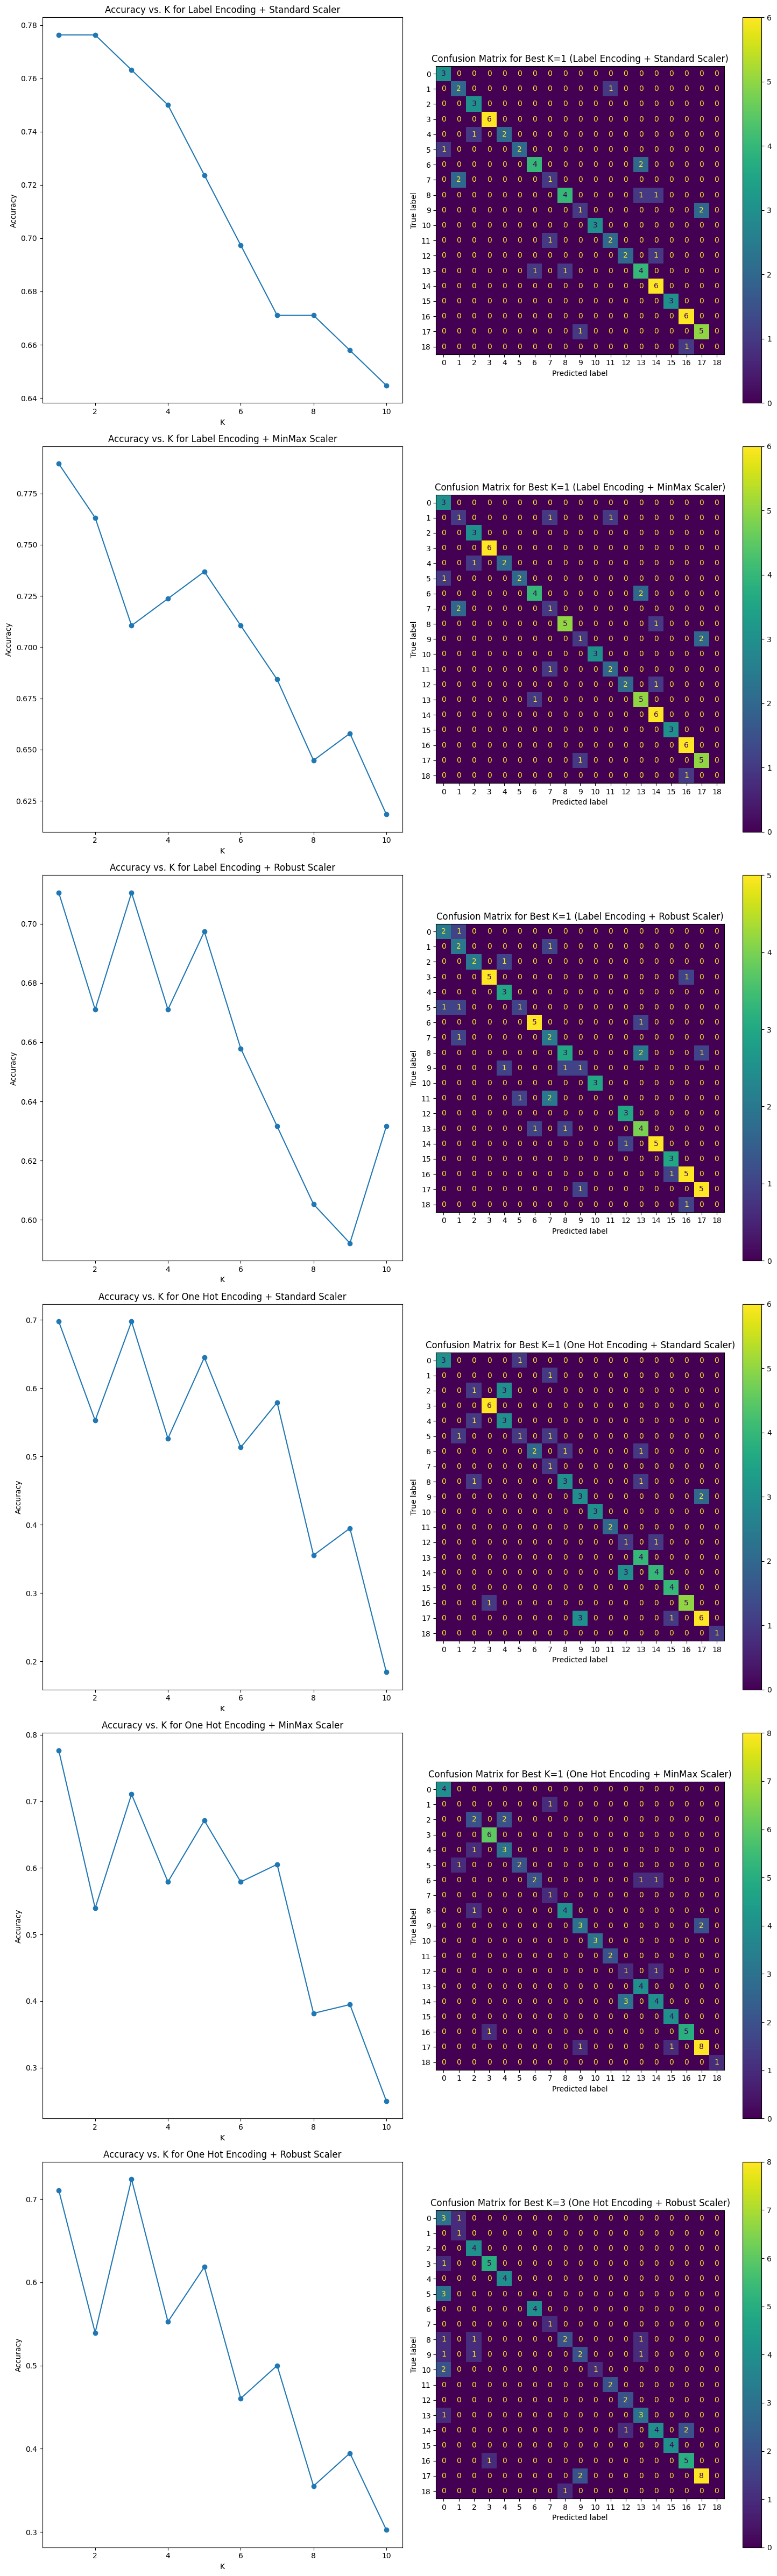

Summary of Best Accuracies for Each Combination:
Label Encoding + Standard Scaler: Best K = 1 with Accuracy = 0.7763
Label Encoding + MinMax Scaler: Best K = 1 with Accuracy = 0.7895
Label Encoding + Robust Scaler: Best K = 1 with Accuracy = 0.7105
One Hot Encoding + Standard Scaler: Best K = 1 with Accuracy = 0.6974
One Hot Encoding + MinMax Scaler: Best K = 1 with Accuracy = 0.7763
One Hot Encoding + Robust Scaler: Best K = 3 with Accuracy = 0.7237


In [60]:

transformations = [
    ('Label Encoding', LabelEncoder()),
    ('One Hot Encoding', OneHotEncoder())
]
scalers = [
    ('Standard Scaler', StandardScaler()),
    ('MinMax Scaler', MinMaxScaler()),
    ('Robust Scaler', RobustScaler())
]

# Adjust the figure layout
total_plots = len(transformations) * len(scalers)
fig, axs = plt.subplots(total_plots, 2, figsize=(15, 8 * total_plots))

# Initialize an empty list to store summary results
summary_results = []

# Dictionary to store X_train and Y_train for each scenario
train_datasets = {}

for i, (trans_name, encoder) in enumerate(transformations):
    for j, (scaler_name, scaler) in enumerate(scalers):
        plot_row = i * len(scalers) + j
        
        # Your existing code for processing and evaluating the model

        # Prepare the data
        df_temp = df_cleaned.copy()
        X = df_temp.drop('label', axis=1)
        y = df_temp['label']

        # Encode labels
        if trans_name == 'One Hot Encoding':
            y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
        else:
            y_encoded = encoder.fit_transform(y)

        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded if trans_name == 'Label Encoding' else None)
        
        # Store X_train and Y_train
        key = f"{trans_name} + {scaler_name}"
        train_datasets[key] = (X_train, y_train)
 
        # Scaling
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        acc_scores = []
        for k in range(1, 11):
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train_scaled, y_train)
            y_pred = knn.predict(X_test_scaled)

            if trans_name == 'One Hot Encoding':
                y_test_single = np.argmax(y_test, axis=1)
                y_pred_single = np.argmax(y_pred, axis=1)
                acc = accuracy_score(y_test_single, y_pred_single)
            else:
                acc = accuracy_score(y_test, y_pred)
            
            acc_scores.append(acc)

        best_k = np.argmax(acc_scores) + 1
        best_acc = max(acc_scores)
        
        # Store the best result for this combination
        summary_results.append((trans_name, scaler_name, best_k, best_acc))

        # Plot accuracy vs. k
        axs[plot_row, 0].plot(range(1, 11), acc_scores, marker='o')
        axs[plot_row, 0].set_title(f'Accuracy vs. K for {trans_name} + {scaler_name}')
        axs[plot_row, 0].set_xlabel('K')
        axs[plot_row, 0].set_ylabel('Accuracy')

        # Plot confusion matrix for the best k
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        if trans_name == 'One Hot Encoding':
            cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        else:
            cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        disp.plot(ax=axs[plot_row, 1])
        axs[plot_row, 1].set_title(f'Confusion Matrix for Best K={best_k} ({trans_name} + {scaler_name})')

plt.tight_layout()
plt.show()

# Print the summary of best accuracies
print("Summary of Best Accuracies for Each Combination:")
for trans_name, scaler_name, best_k, best_acc in summary_results:
    print(f"{trans_name} + {scaler_name}: Best K = {best_k} with Accuracy = {best_acc:.4f}")


Below url's exists in data exactly 10 times
while the others observed either less or more than the visit number. When we tried just these URLs results are better in terms of accuracy.

In [238]:
# List of labels to keep
labels_to_keep = ['bbc_uk', 'nytimes', 'foxnews', 'express_uk', 'cnbc', 
                  'abc', 'msn', 'dailymail', 'news18', 'ndtv']

# Filtering df_cleaned to only include rows with the specified labels
df_filtered = df_cleaned[df_cleaned['label'].isin(labels_to_keep)]



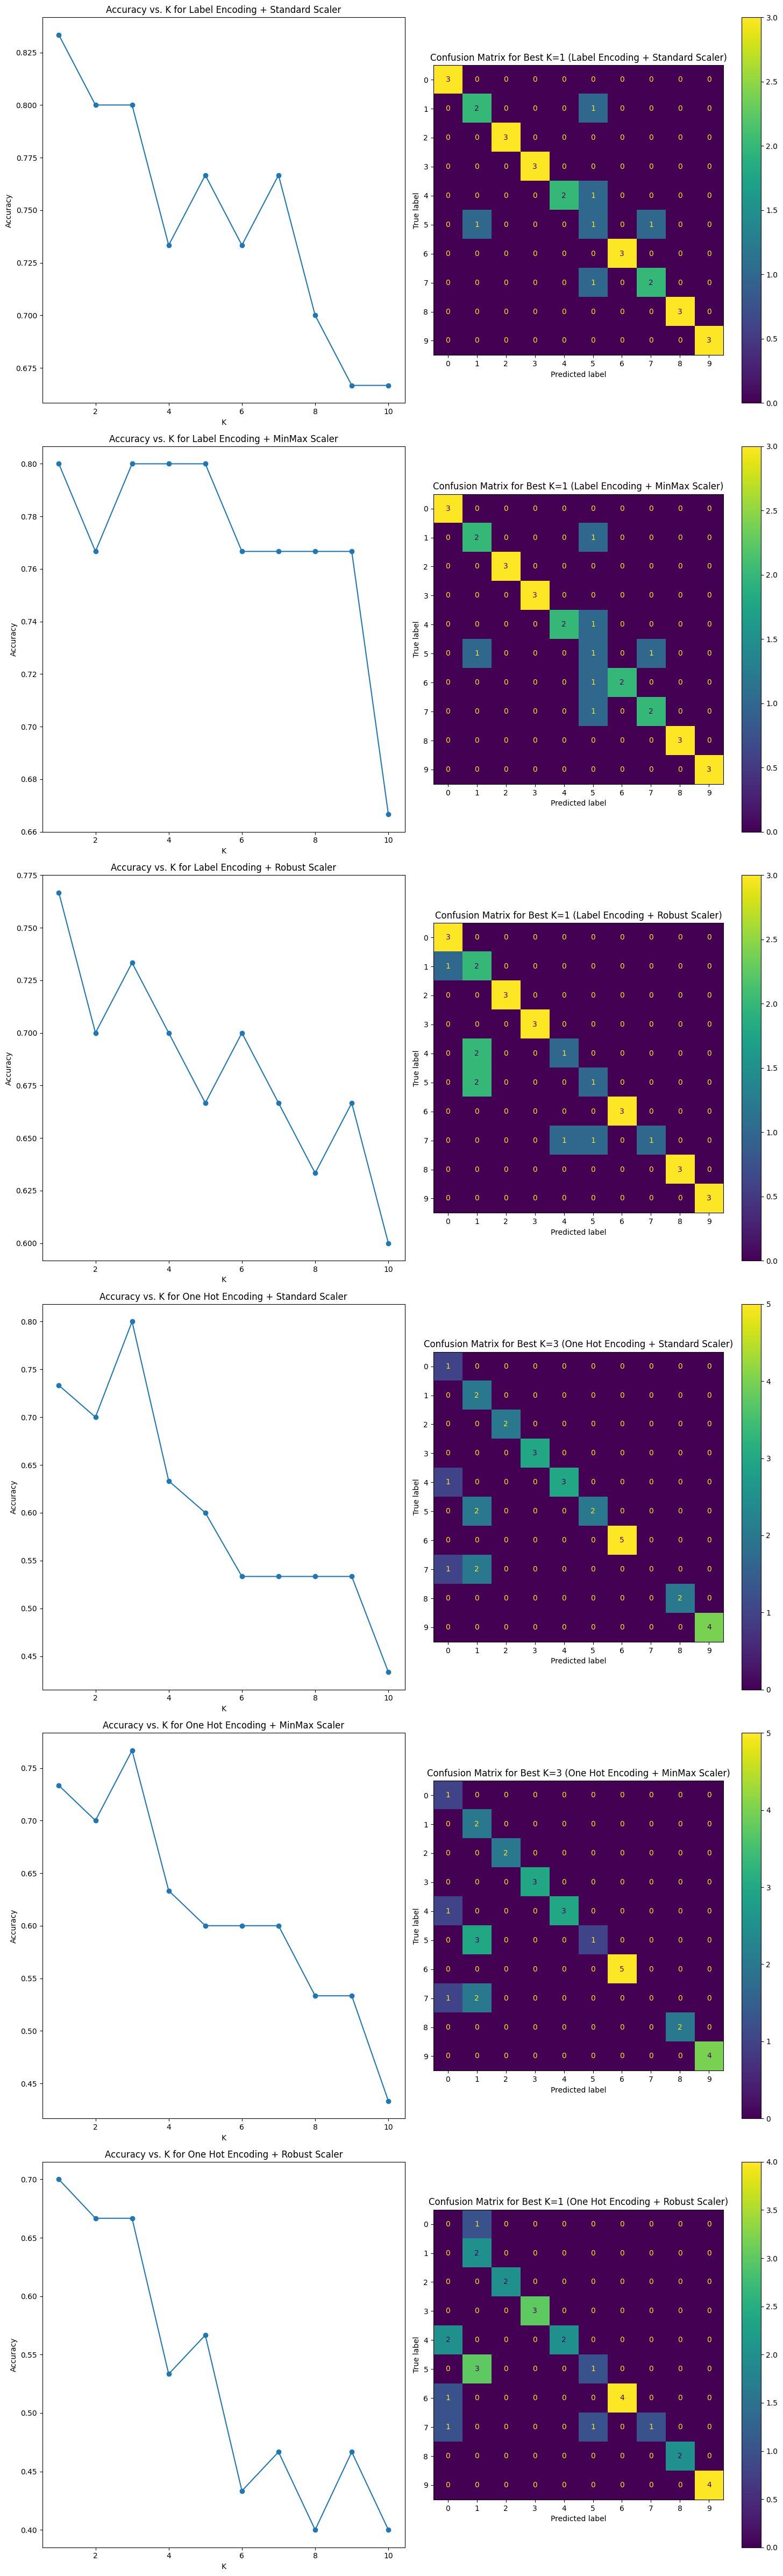

Summary of Best Accuracies for Each Combination:
Label Encoding + Standard Scaler: Best K = 1 with Accuracy = 0.8333
Label Encoding + MinMax Scaler: Best K = 1 with Accuracy = 0.8000
Label Encoding + Robust Scaler: Best K = 1 with Accuracy = 0.7667
One Hot Encoding + Standard Scaler: Best K = 3 with Accuracy = 0.8000
One Hot Encoding + MinMax Scaler: Best K = 3 with Accuracy = 0.7667
One Hot Encoding + Robust Scaler: Best K = 1 with Accuracy = 0.7000


In [240]:


transformations = [
    ('Label Encoding', LabelEncoder()),
    ('One Hot Encoding', OneHotEncoder())
]
scalers = [
    ('Standard Scaler', StandardScaler()),
    ('MinMax Scaler', MinMaxScaler()),
    ('Robust Scaler', RobustScaler())
]

# Adjust the figure layout
total_plots = len(transformations) * len(scalers)
fig, axs = plt.subplots(total_plots, 2, figsize=(15, 8 * total_plots))

# Initialize an empty list to store summary results
summary_results = []

for i, (trans_name, encoder) in enumerate(transformations):
    for j, (scaler_name, scaler) in enumerate(scalers):
        plot_row = i * len(scalers) + j
        
        # Your existing code for processing and evaluating the model

        # Prepare the data
        df_temp = df_filtered.copy()
        X = df_temp.drop('label', axis=1)
        y = df_temp['label']

        # Encode labels
        if trans_name == 'One Hot Encoding':
            y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()
        else:
            y_encoded = encoder.fit_transform(y)

        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded if trans_name == 'Label Encoding' else None)

        # Scaling
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        acc_scores = []
        for k in range(1, 11):
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train_scaled, y_train)
            y_pred = knn.predict(X_test_scaled)

            if trans_name == 'One Hot Encoding':
                y_test_single = np.argmax(y_test, axis=1)
                y_pred_single = np.argmax(y_pred, axis=1)
                acc = accuracy_score(y_test_single, y_pred_single)
            else:
                acc = accuracy_score(y_test, y_pred)
            
            acc_scores.append(acc)

        best_k = np.argmax(acc_scores) + 1
        best_acc = max(acc_scores)
        
        # Store the best result for this combination
        summary_results.append((trans_name, scaler_name, best_k, best_acc))

        # Plot accuracy vs. k
        axs[plot_row, 0].plot(range(1, 11), acc_scores, marker='o')
        axs[plot_row, 0].set_title(f'Accuracy vs. K for {trans_name} + {scaler_name}')
        axs[plot_row, 0].set_xlabel('K')
        axs[plot_row, 0].set_ylabel('Accuracy')

        # Plot confusion matrix for the best k
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        if trans_name == 'One Hot Encoding':
            cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        else:
            cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        disp.plot(ax=axs[plot_row, 1])
        axs[plot_row, 1].set_title(f'Confusion Matrix for Best K={best_k} ({trans_name} + {scaler_name})')

plt.tight_layout()
plt.show()

# Print the summary of best accuracies
print("Summary of Best Accuracies for Each Combination:")
for trans_name, scaler_name, best_k, best_acc in summary_results:
    print(f"{trans_name} + {scaler_name}: Best K = {best_k} with Accuracy = {best_acc:.4f}")


## ALTERNATE DATASET  WITH 3 REQUESTS PER URL



Same Procedure Applied to alternate dataset that consists 3 visits per url.

In [16]:
alternated_df

,Unnamed: 0,source_ip,destination_ip,protocol,top_layer,packet_length,packet_number,capture_time,timestamp,source_port,...,dns_query,dns_response,dns_type,dns_class,query_count,answer_count,authority_count,udp_source_port,udp_destination_port,label
0,0,23.51.246.151,172.20.146.77,6,TCP,66,1,2024-03-28 01:34:33.985252,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
1,1,172.20.146.77,23.51.246.151,6,TCP,54,2,2024-03-28 01:34:33.985401,1.711586e+09,38640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
2,2,172.20.146.77,23.51.246.151,6,TLS,571,3,2024-03-28 01:34:34.061599,1.711586e+09,38640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
3,3,23.51.246.151,172.20.146.77,6,TCP,54,4,2024-03-28 01:34:34.122415,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
4,4,23.51.246.151,172.20.146.77,6,TLS,1394,5,2024-03-28 01:34:34.145926,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10899,701,172.20.146.77,76.223.84.192,6,TCP,54,702,2024-03-28 01:46:24.489844,1.711587e+09,49534.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10900,702,87.248.107.206,172.20.146.77,6,TCP,54,703,2024-03-28 01:46:24.496116,1.711587e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10901,703,87.248.107.206,172.20.146.77,6,TCP,54,704,2024-03-28 01:46:24.496132,1.711587e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10902,704,172.20.146.77,87.248.107.206,6,TCP,54,705,2024-03-28 01:46:24.496140,1.711587e+09,48898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo


In [17]:
alternated_df['protocol'] = alternated_df['protocol'].astype(int)

# Filter for TCP/TLS and UDP/DNS traffic, assuming protocol 6 is TCP and 17 is UDP
df_tcp_tls_alt = alternated_df[alternated_df["protocol"] == 6]
df_udp_dns_alt = alternated_df[alternated_df["protocol"] == 17]


df_flows_tcp_alt = df_tcp_tls_alt.groupby(["source_ip", "destination_ip", "source_port", "destination_port"])
df_flows_udp_alt=df_udp_dns_alt.groupby(["source_ip", "destination_ip", "udp_source_port", "udp_destination_port"])


In [18]:
df_udp_dns_alt

,Unnamed: 0,source_ip,destination_ip,protocol,top_layer,packet_length,packet_number,capture_time,timestamp,source_port,...,dns_query,dns_response,dns_type,dns_class,query_count,answer_count,authority_count,udp_source_port,udp_destination_port,label
207,207,172.20.146.77,172.20.144.1,17,DNS,78,208,2024-03-28 01:34:34.408043,1.711586e+09,NaN,...,www.indiatimes.com,NaN,1.0,0x0001,1.0,0.0,0.0,39833.0,53.0,indiatimes
208,208,172.20.146.77,172.20.144.1,17,DNS,78,209,2024-03-28 01:34:34.408049,1.711586e+09,NaN,...,www.indiatimes.com,NaN,28.0,0x0001,1.0,0.0,0.0,39833.0,53.0,indiatimes
209,209,172.20.144.1,172.20.146.77,17,DNS,260,210,2024-03-28 01:34:34.408889,1.711586e+09,NaN,...,www.indiatimes.com,www.indiatimes.com,1.0,0x0001,1.0,3.0,0.0,53.0,39833.0,indiatimes
210,210,172.20.144.1,172.20.146.77,17,DNS,356,211,2024-03-28 01:34:34.409218,1.711586e+09,NaN,...,www.indiatimes.com,www.indiatimes.com,28.0,0x0001,1.0,6.0,0.0,53.0,39833.0,indiatimes
214,214,172.20.144.1,239.255.255.250,17,SSDP,167,215,2024-03-28 01:34:34.484098,1.711586e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61087.0,1900.0,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10625,427,172.20.144.1,172.20.146.77,17,DNS,284,428,2024-03-28 01:46:23.510609,1.711587e+09,NaN,...,www.news.yahoo.com,www.news.yahoo.com,28.0,0x0001,1.0,3.0,0.0,53.0,52489.0,news_yahoo
10656,458,172.20.146.77,172.20.144.1,17,DNS,73,459,2024-03-28 01:46:23.763195,1.711587e+09,NaN,...,www.yahoo.com,NaN,1.0,0x0001,1.0,0.0,0.0,56719.0,53.0,news_yahoo
10657,459,172.20.146.77,172.20.144.1,17,DNS,73,460,2024-03-28 01:46:23.763199,1.711587e+09,NaN,...,www.yahoo.com,NaN,28.0,0x0001,1.0,0.0,0.0,56719.0,53.0,news_yahoo
10658,460,172.20.144.1,172.20.146.77,17,DNS,194,461,2024-03-28 01:46:23.764080,1.711587e+09,NaN,...,www.yahoo.com,www.yahoo.com,1.0,0x0001,1.0,3.0,0.0,53.0,56719.0,news_yahoo


In [19]:
df_tcp_tls_alt

,Unnamed: 0,source_ip,destination_ip,protocol,top_layer,packet_length,packet_number,capture_time,timestamp,source_port,...,dns_query,dns_response,dns_type,dns_class,query_count,answer_count,authority_count,udp_source_port,udp_destination_port,label
0,0,23.51.246.151,172.20.146.77,6,TCP,66,1,2024-03-28 01:34:33.985252,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
1,1,172.20.146.77,23.51.246.151,6,TCP,54,2,2024-03-28 01:34:33.985401,1.711586e+09,38640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
2,2,172.20.146.77,23.51.246.151,6,TLS,571,3,2024-03-28 01:34:34.061599,1.711586e+09,38640.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
3,3,23.51.246.151,172.20.146.77,6,TCP,54,4,2024-03-28 01:34:34.122415,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
4,4,23.51.246.151,172.20.146.77,6,TLS,1394,5,2024-03-28 01:34:34.145926,1.711586e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,indiatimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10899,701,172.20.146.77,76.223.84.192,6,TCP,54,702,2024-03-28 01:46:24.489844,1.711587e+09,49534.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10900,702,87.248.107.206,172.20.146.77,6,TCP,54,703,2024-03-28 01:46:24.496116,1.711587e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10901,703,87.248.107.206,172.20.146.77,6,TCP,54,704,2024-03-28 01:46:24.496132,1.711587e+09,443.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo
10902,704,172.20.146.77,87.248.107.206,6,TCP,54,705,2024-03-28 01:46:24.496140,1.711587e+09,48898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,news_yahoo


In [20]:
import pandas as pd
#my ip today 172.20.146.77

def extract_features_alt(flow, df_flow):
    flow_features = {}
    # Corrected logical AND operator and added proper indentation
    #print(flow[0])
    if flow[0]=='172.20.146.77' :
        flow_features['direction'] = 'uplink'
        #print("uplink")
    else:
        flow_features['direction'] = 'downlink'

    # Proper indentation continued for the rest of the function
    flow_features['num_packets'] = len(df_flow)
    pkt_sizes = df_flow['packet_length'].astype(float)
    flow_features['total_bytes'] = pkt_sizes.sum()
    flow_features['min_pkt_size'] = pkt_sizes.min()
    flow_features['max_pkt_size'] = pkt_sizes.max()
    flow_features['mean_pkt_size'] = pkt_sizes.mean()
    flow_features['std_pkt_size'] = pkt_sizes.std()
    
    
    # Ensure the 'frame.time' column is in a correct format to be converted to datetime
    iat = pd.to_datetime(df_flow['capture_time']).diff().dt.total_seconds().iloc[1:]
    flow_features['min_iat'] = iat.min()
    flow_features['max_iat'] = iat.max()
    flow_features['mean_iat'] = iat.mean()
    flow_features['std_iat'] = iat.std()
    flow_features['dur'] = iat.sum()
    flow_features['label']=df_flow['label']
    
    
    flow_features['destinationport'] = flow[3]
    flow_features['sourceport'] = flow[2]
    
    return flow_features



In [21]:

flow_features_df_tcp_alt=pd.DataFrame()

flow_features_list_alt = []
for flow, df_flow in df_flows_tcp_alt:
    # Extract features for the flow
    features = extract_features_alt(flow, df_flow)
    #print(flow,df_flow)
    features['label'] = df_flow.iloc[0]["label"]
    # Append the combined dictionary to the list
    flow_features_list_alt.append(features)
    
    
flow_features_df_tcp_alt = pd.DataFrame(flow_features_list_alt)

flow_features_df_tcp_alt


,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,label,destinationport,sourceport
0,downlink,8,6030.0,54.0,1705.0,753.750000,753.560074,0.000001,1.654891,0.263411,0.614529,1.843879,google_news,46544.0,443.0
1,downlink,164,390843.0,54.0,13454.0,2383.189024,2224.200003,0.000000,1.198414,0.012809,0.099548,2.087831,google_news,46546.0,443.0
2,downlink,9,6092.0,54.0,1394.0,676.888889,669.600524,0.000000,1.308876,0.181762,0.456556,1.454095,google_news,46548.0,443.0
3,downlink,112,304891.0,54.0,9434.0,2722.241071,1929.682891,0.000000,43.220634,0.393752,4.101928,43.706509,google_news,46550.0,443.0
4,downlink,8,6038.0,54.0,2734.0,754.750000,981.371453,0.000000,0.620712,0.113832,0.227746,0.796821,google_news,46552.0,443.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,downlink,96,276594.0,54.0,13454.0,2881.187500,2831.555943,0.000000,0.989726,0.018091,0.103705,1.718624,news_yahoo,48894.0,443.0
152,downlink,122,277983.0,54.0,12780.0,2278.549180,2147.353066,0.000000,0.150786,0.005699,0.020576,0.689574,news_yahoo,48898.0,443.0
153,downlink,132,311721.0,54.0,4074.0,2361.522727,975.018939,0.000000,8.541154,0.129633,1.018138,16.981871,washingtonpost,58758.0,443.0
154,downlink,132,311687.0,54.0,5414.0,2361.265152,958.445209,0.000000,10.611508,0.145302,1.155255,19.034578,washingtonpost,58760.0,443.0


In [22]:
flow_features_list_udp_alt = []

flow_features_df_udp_alt=pd.DataFrame()


for flow, df_flow in df_flows_udp_alt:
    # Extract features for the flow
    features = extract_features_alt(flow, df_flow)
    # Extract label from the first row in the group
    features['label'] = df_flow.iloc[0]["label"]
    flow_features_list_udp_alt.append(features)


# Create DataFrames from the lists of dictionaries
flow_features_df_udp_alt = pd.DataFrame(flow_features_list_udp_alt)
flow_features_df_udp_alt

,direction,num_packets,total_bytes,min_pkt_size,max_pkt_size,mean_pkt_size,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,label,destinationport,sourceport
0,downlink,2,240.0,100.0,140.0,120.0,28.284271,0.000265,0.000265,0.000265,NaN,0.000265,ndtv,33088.0,53.0
1,downlink,2,400.0,194.0,206.0,200.0,8.485281,0.000266,0.000266,0.000266,NaN,0.000266,theguardian,33195.0,53.0
2,downlink,2,224.0,106.0,118.0,112.0,8.485281,0.000367,0.000367,0.000367,NaN,0.000367,google_news,33324.0,53.0
3,downlink,2,178.0,74.0,104.0,89.0,21.213203,0.051615,0.051615,0.051615,NaN,0.051615,nypost,34160.0,53.0
4,downlink,2,406.0,186.0,220.0,203.0,24.041631,0.046595,0.046595,0.046595,NaN,0.046595,bbc_uk,34802.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,uplink,2,144.0,72.0,72.0,72.0,0.000000,0.000008,0.000008,0.000008,NaN,0.000008,ndtv,53.0,59252.0
170,uplink,2,158.0,79.0,79.0,79.0,0.000000,0.000007,0.000007,0.000007,NaN,0.000007,dailymail,53.0,59451.0
171,uplink,2,160.0,80.0,80.0,80.0,0.000000,0.000007,0.000007,0.000007,NaN,0.000007,timesofindia,53.0,59791.0
172,uplink,2,162.0,81.0,81.0,81.0,0.000000,0.000006,0.000006,0.000006,NaN,0.000006,finance_yahoo,53.0,60009.0


In [23]:

df=flow_features_df_tcp_alt

# Splitting the DataFrame based on direction
df_uplink = df[df['direction'] == 'uplink'].copy()
df_downlink = df[df['direction'] == 'downlink'].copy()

# Separating featurse as down and up
uplink_rename_cols = {col: f"{col}_up" for col in df_uplink.columns if col not in ['direction', 'label', 'sourceport', 'destinationport']}
downlink_rename_cols = {col: f"{col}_down" for col in df_downlink.columns if col not in ['direction', 'label', 'sourceport', 'destinationport']}

df_uplink.rename(columns=uplink_rename_cols, inplace=True)
df_downlink.rename(columns=downlink_rename_cols, inplace=True)

# Adding '_up' and '_down' suffixes for ports to use them in the merge operation
df_uplink.rename(columns={'sourceport': 'sourceport_up', 'destinationport': 'destinationport_up'}, inplace=True)
df_downlink.rename(columns={'sourceport': 'sourceport_down', 'destinationport': 'destinationport_down'}, inplace=True)

# Flows merged to be able to create a dataset per label
df_combined = pd.merge(df_downlink, df_uplink, 
                       left_on=['label', 'destinationport_down', 'sourceport_down'], 
                       right_on=['label', 'sourceport_up', 'destinationport_up'], 
                       how='inner')

df_combined.drop(columns=['sourceport_up', 'destinationport_up', 'sourceport_down', 'destinationport_down'], inplace=True)




if 'direction_x' and 'direction_y' in df_combined.columns:
    df_combined.drop(columns=['direction_x','direction_y'], inplace=True)
cols = [col for col in df_combined.columns if col != 'label']

cols = ['label'] + cols

df_combined = df_combined[cols]

df_cleaned_alt = df_combined.dropna()
df_cleaned_alt

,label,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,mean_iat_down,...,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,dur_up
0,google_news,8,6030.0,54.0,1705.0,753.750000,753.560074,0.000001,1.654891,0.263411,...,1383.0,54.0,571.0,125.727273,157.187844,0.000026,1.618904,0.188231,0.503397,1.882308
1,google_news,164,390843.0,54.0,13454.0,2383.189024,2224.200003,0.000000,1.198414,0.012809,...,9848.0,54.0,571.0,63.948052,54.259699,0.000001,1.157845,0.013925,0.099815,2.130561
2,google_news,9,6092.0,54.0,1394.0,676.888889,669.600524,0.000000,1.308876,0.181762,...,1449.0,54.0,571.0,120.750000,150.861240,0.000006,1.259353,0.135551,0.373441,1.491057
3,google_news,112,304891.0,54.0,9434.0,2722.241071,1929.682891,0.000000,43.220634,0.393752,...,6602.0,54.0,571.0,66.686869,67.494769,0.000001,43.174342,0.446366,4.360708,43.743821
4,google_news,8,6038.0,54.0,2734.0,754.750000,981.371453,0.000000,0.620712,0.113832,...,1395.0,54.0,571.0,126.818182,156.681089,0.000030,0.567402,0.083572,0.172067,0.835724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,news_yahoo,96,276594.0,54.0,13454.0,2881.187500,2831.555943,0.000000,0.989726,0.018091,...,5800.0,54.0,571.0,63.043478,56.861295,0.000001,0.944272,0.019354,0.100889,1.761210
74,news_yahoo,122,277983.0,54.0,12780.0,2278.549180,2147.353066,0.000000,0.150786,0.005699,...,6886.0,54.0,571.0,60.938053,51.385324,0.000001,0.167512,0.006524,0.022899,0.730689
75,washingtonpost,132,311721.0,54.0,4074.0,2361.522727,975.018939,0.000000,8.541154,0.129633,...,7920.0,54.0,571.0,60.000000,47.851711,0.000001,8.488198,0.130084,1.016776,17.040989
76,washingtonpost,132,311687.0,54.0,5414.0,2361.265152,958.445209,0.000000,10.611508,0.145302,...,8028.0,54.0,571.0,59.910448,47.496175,0.000001,10.546321,0.143499,1.144237,19.085378


In [24]:
# Count of each unique label in the 'label' column
label_counts = df_cleaned_alt['label'].value_counts()

label_counts

label
google_news       6
theguardian       6
news_yahoo        6
cnn               6
finance_yahoo     6
nypost            6
timesofindia      6
msn               3
indiatimes        3
ndtv              3
dailymail         3
cnbc              3
news18            3
abc               3
bbc_uk            3
express_uk        3
foxnews           3
nytimes           3
washingtonpost    3
Name: count, dtype: int64

In [38]:
df_filtered = df_cleaned_alt.groupby('label').apply(lambda x: x.sample(n=3, replace=True)).reset_index(drop=True)


In [39]:
df_filtered

,label,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,mean_iat_down,...,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,dur_up
0,abc,33,54728.0,54.0,2734.0,1658.424242,1074.922585,0.0,0.322467,0.019413,...,2362.0,54.0,571.0,81.448276,100.048769,0.000001,0.276659,0.024095,0.054407,0.674647
1,abc,31,54598.0,54.0,2734.0,1761.225806,1157.364613,0.0,0.401248,0.022195,...,2308.0,54.0,571.0,82.428571,101.742751,0.000001,0.361394,0.026585,0.069803,0.717795
2,abc,30,54358.0,54.0,2734.0,1811.933333,1181.884233,0.0,0.191592,0.014169,...,2524.0,54.0,571.0,78.875000,95.431364,0.000002,0.137878,0.014573,0.028381,0.451768
3,bbc_uk,37,70968.0,54.0,4074.0,1918.054054,1339.759223,0.0,0.277101,0.014379,...,2441.0,54.0,571.0,78.741935,96.671943,0.000003,0.234914,0.018762,0.044869,0.562874
4,bbc_uk,34,70806.0,54.0,6754.0,2082.529412,1655.876830,0.0,0.095908,0.008233,...,2333.0,54.0,571.0,80.448276,99.831138,0.000001,0.053930,0.011060,0.017006,0.309687
5,bbc_uk,34,70806.0,54.0,6754.0,2082.529412,1655.876830,0.0,0.095908,0.008233,...,2333.0,54.0,571.0,80.448276,99.831138,0.000001,0.053930,0.011060,0.017006,0.309687
6,cnbc,105,308628.0,54.0,9434.0,2939.314286,2104.791463,0.0,0.587186,0.011026,...,6661.0,54.0,571.0,64.669903,60.692473,0.000001,0.545082,0.011676,0.057619,1.190955
7,cnbc,111,308952.0,54.0,8094.0,2783.351351,1890.347571,0.0,0.118736,0.005155,...,6541.0,54.0,571.0,64.762376,61.286891,0.000001,0.127272,0.006149,0.017951,0.614899
8,cnbc,131,310098.0,54.0,4074.0,2367.160305,1006.618718,0.0,0.649926,0.010707,...,7837.0,54.0,571.0,62.696000,55.201570,0.000001,0.608375,0.011618,0.059018,1.440619
9,cnn,161,452984.0,54.0,8094.0,2813.565217,1697.455694,0.0,1.094270,0.009591,...,9339.0,54.0,571.0,59.865385,47.119216,0.000001,1.048863,0.010137,0.084981,1.571227


In [40]:
# Count of each unique label in the 'label' column
label_counts = df_filtered['label'].value_counts()

label_counts


label
abc               3
msn               3
timesofindia      3
theguardian       3
nytimes           3
nypost            3
news_yahoo        3
news18            3
ndtv              3
indiatimes        3
bbc_uk            3
google_news       3
foxnews           3
finance_yahoo     3
express_uk        3
dailymail         3
cnn               3
cnbc              3
washingtonpost    3
Name: count, dtype: int64

For the sake of easiness Label Encoding and Standard Scaler used since we obtained best results in previous scenario with this settings.

In [45]:
train_datasets["Label Encoding + Standard Scaler"][0]

,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,mean_iat_down,std_iat_down,...,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,dur_up
188,142,307263.0,54.0,10774.0,2163.823944,1708.324152,0.0,55.364860,0.396364,4.662274,...,8390.0,54.0,571.0,64.045802,58.826847,0.000001,55.324390,0.430181,4.851895,55.923558
244,99,277641.0,54.0,13454.0,2804.454545,2438.377058,0.0,1.018239,0.018884,0.104783,...,6046.0,54.0,571.0,62.329897,55.408280,0.000002,0.970683,0.019760,0.101738,1.896991
29,32,58861.0,54.0,2930.0,1839.406250,983.317980,0.0,0.279339,0.015384,0.053913,...,2229.0,54.0,571.0,82.555556,103.527898,0.000002,0.237328,0.020156,0.048453,0.524068
94,9,5948.0,54.0,2734.0,660.888889,1026.513084,0.0,0.113434,0.022850,0.040291,...,1413.0,54.0,571.0,117.750000,150.729212,0.000002,0.060771,0.020396,0.027033,0.224354
23,42,59846.0,54.0,2930.0,1424.904762,937.434455,0.0,0.273651,0.017609,0.048249,...,2661.0,54.0,571.0,76.028571,91.346298,0.000002,0.240391,0.022471,0.049037,0.764013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,41,56282.0,54.0,4224.0,1372.731707,1404.755762,0.0,0.449125,0.021510,0.072837,...,2445.0,54.0,571.0,116.428571,147.999180,0.000089,0.409253,0.043234,0.091088,0.864690
92,39,71227.0,54.0,4074.0,1826.333333,1158.415850,0.0,0.096925,0.007372,0.020803,...,2443.0,54.0,571.0,78.806452,96.769974,0.000002,0.058533,0.010614,0.017384,0.318420
225,13,12040.0,54.0,4150.0,926.153846,1211.878490,0.0,1.686488,0.157991,0.482630,...,1648.0,54.0,571.0,103.000000,132.351552,0.000001,1.635748,0.129430,0.417701,1.941457
167,38,56345.0,54.0,4393.0,1482.763158,1577.159856,0.0,0.478736,0.023824,0.080395,...,2661.0,54.0,571.0,106.440000,137.108558,0.000038,0.442911,0.036783,0.091405,0.882800


In [70]:
X_train=train_datasets["Label Encoding + MinMax Scaler"][0]
Y_train=train_datasets["Label Encoding + MinMax Scaler"][1]

transformations = [
    ('Label Encoding', LabelEncoder())]
scalers = [
    ('MinMax Scaler', MinMaxScaler())]



In [75]:
df_cleaned

,label,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,mean_iat_down,...,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,dur_up
0,ndtv,46,82361.0,54.0,5414.0,1790.456522,1101.195486,0.0,0.293340,0.014429,...,2834.0,54.0,571.0,74.578947,87.799105,0.000002,0.251043,0.018742,0.046284,0.693448
1,ndtv,42,82115.0,54.0,4074.0,1955.119048,1047.058766,0.0,0.275683,0.012483,...,2996.0,54.0,571.0,73.073171,84.616603,0.000002,0.244150,0.013850,0.040285,0.553985
2,ndtv,40,82007.0,54.0,6754.0,2050.175000,1370.679055,0.0,0.285734,0.013230,...,2726.0,54.0,571.0,75.722222,90.131209,0.000002,0.252871,0.015873,0.044253,0.555543
3,ndtv,47,82376.0,54.0,4074.0,1752.680851,1010.820827,0.0,0.298303,0.011806,...,2888.0,54.0,571.0,74.051282,86.698798,0.000002,0.262030,0.015143,0.043671,0.575423
4,ndtv,40,82005.0,54.0,4074.0,2050.125000,1110.985730,0.0,0.287035,0.016934,...,2726.0,54.0,571.0,75.722222,90.131209,0.000001,0.250943,0.020264,0.050490,0.709234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,news_yahoo,145,278566.0,54.0,8094.0,1921.144828,1320.040193,0.0,1.123520,0.012217,...,7882.0,54.0,571.0,60.167939,47.755330,0.000001,1.070033,0.013877,0.095653,1.804002
249,news_yahoo,136,278218.0,54.0,9434.0,2045.720588,1738.608625,0.0,1.413944,0.015336,...,7822.0,54.0,571.0,60.635659,48.117197,0.000001,1.344248,0.016747,0.120173,2.143570
250,news_yahoo,94,276082.0,54.0,13454.0,2937.042553,2250.430811,0.0,1.179341,0.023560,...,6100.0,54.0,571.0,62.244898,55.128353,0.000001,1.139836,0.023057,0.127986,2.236501
251,news_yahoo,102,276438.0,54.0,12114.0,2710.176471,2216.966652,0.0,1.576447,0.023575,...,6208.0,54.0,571.0,62.080000,54.580990,0.000002,1.522639,0.024432,0.154428,2.418785


In [76]:
df_filtered

,label,num_packets_down,total_bytes_down,min_pkt_size_down,max_pkt_size_down,mean_pkt_size_down,std_pkt_size_down,min_iat_down,max_iat_down,mean_iat_down,...,total_bytes_up,min_pkt_size_up,max_pkt_size_up,mean_pkt_size_up,std_pkt_size_up,min_iat_up,max_iat_up,mean_iat_up,std_iat_up,dur_up
0,abc,33,54728.0,54.0,2734.0,1658.424242,1074.922585,0.0,0.322467,0.019413,...,2362.0,54.0,571.0,81.448276,100.048769,0.000001,0.276659,0.024095,0.054407,0.674647
1,abc,31,54598.0,54.0,2734.0,1761.225806,1157.364613,0.0,0.401248,0.022195,...,2308.0,54.0,571.0,82.428571,101.742751,0.000001,0.361394,0.026585,0.069803,0.717795
2,abc,30,54358.0,54.0,2734.0,1811.933333,1181.884233,0.0,0.191592,0.014169,...,2524.0,54.0,571.0,78.875000,95.431364,0.000002,0.137878,0.014573,0.028381,0.451768
3,bbc_uk,37,70968.0,54.0,4074.0,1918.054054,1339.759223,0.0,0.277101,0.014379,...,2441.0,54.0,571.0,78.741935,96.671943,0.000003,0.234914,0.018762,0.044869,0.562874
4,bbc_uk,34,70806.0,54.0,6754.0,2082.529412,1655.876830,0.0,0.095908,0.008233,...,2333.0,54.0,571.0,80.448276,99.831138,0.000001,0.053930,0.011060,0.017006,0.309687
5,bbc_uk,34,70806.0,54.0,6754.0,2082.529412,1655.876830,0.0,0.095908,0.008233,...,2333.0,54.0,571.0,80.448276,99.831138,0.000001,0.053930,0.011060,0.017006,0.309687
6,cnbc,105,308628.0,54.0,9434.0,2939.314286,2104.791463,0.0,0.587186,0.011026,...,6661.0,54.0,571.0,64.669903,60.692473,0.000001,0.545082,0.011676,0.057619,1.190955
7,cnbc,111,308952.0,54.0,8094.0,2783.351351,1890.347571,0.0,0.118736,0.005155,...,6541.0,54.0,571.0,64.762376,61.286891,0.000001,0.127272,0.006149,0.017951,0.614899
8,cnbc,131,310098.0,54.0,4074.0,2367.160305,1006.618718,0.0,0.649926,0.010707,...,7837.0,54.0,571.0,62.696000,55.201570,0.000001,0.608375,0.011618,0.059018,1.440619
9,cnn,161,452984.0,54.0,8094.0,2813.565217,1697.455694,0.0,1.094270,0.009591,...,9339.0,54.0,571.0,59.865385,47.119216,0.000001,1.048863,0.010137,0.084981,1.571227


In [77]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

X_train = df_cleaned.drop('label', axis=1)
Y_train = df_cleaned['label']
X_test = df_filtered.drop('label', axis=1)
Y_test = df_filtered['label']

# Initialize LabelEncoder and encode labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


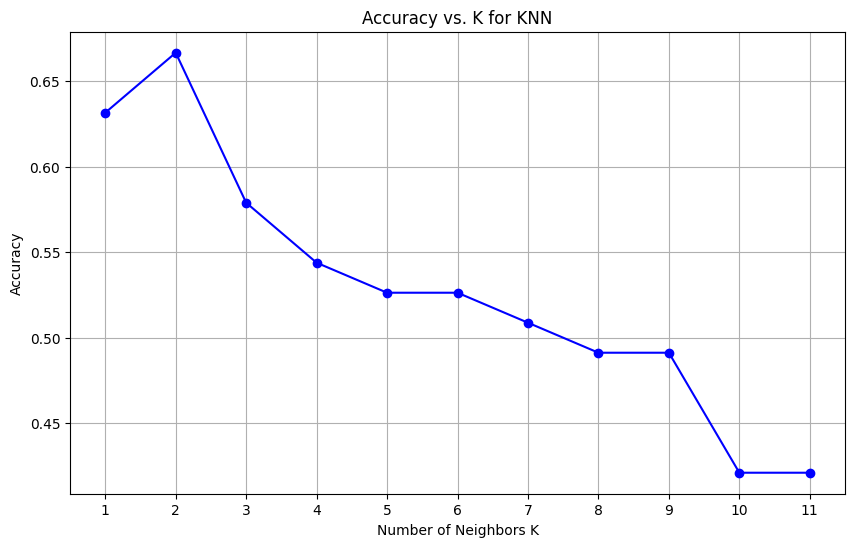

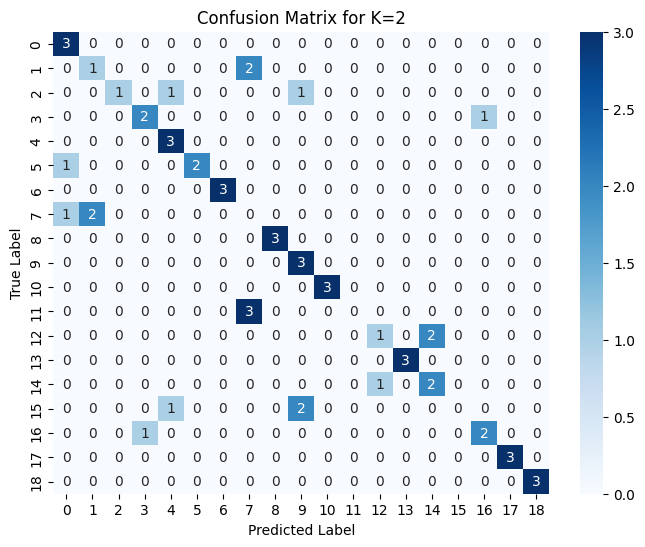

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Number of neighbors to test
k_values = range(1, 12)

# Store accuracies for each k
accuracies = []

for k in k_values:
    # Initialize and train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, Y_train_encoded)
    
    # Make predictions and calculate accuracy
    Y_pred = knn.predict(X_test_scaled)
    accuracy = accuracy_score(Y_test_encoded, Y_pred)
    accuracies.append(accuracy)

# Identify the best k (highest accuracy)
best_k = k_values[np.argmax(accuracies)]

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title('Accuracy vs. K for KNN')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Train the model with the best k and plot the confusion matrix
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, Y_train_encoded)
Y_pred_best = best_knn.predict(X_test_scaled)

conf_matrix = confusion_matrix(Y_test_encoded, Y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for K={best_k}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Conclusion:


From the confusion matrices it can be deducted that 'bbc_uk', 'nytimes', 'foxnews', 'express_uk', 'cnbc', 'abc', 'msn', 'dailymail', 'news18', 'ndtv' are the URLs that their data better classifiable.
Accuracy dropped  %10 from %78 to around %68, different encoding & scaler scenarios applied; accuracy can be enhanced dataset that consist more visits per URL. 
It is obvious for higher k values accuracy drops significantly again with the test data




Fatih Temiz.